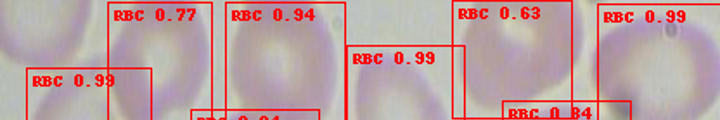

# Introduction

This notebook presents **YOLOv2** applied to the [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset) dataset.

I want to thank _experiencor_ for developing and making public [keras-yolo2](https://github.com/experiencor/keras-yolo2). An indispensable learning resource.

**Resources**

* [YOLOv2](https://pjreddie.com/darknet/yolov2/) - official website and weights download
* [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset) - dataset download
* [keras-yolo2](https://github.com/experiencor/keras-yolo2) - YOLOv2 in Keras by experiencor

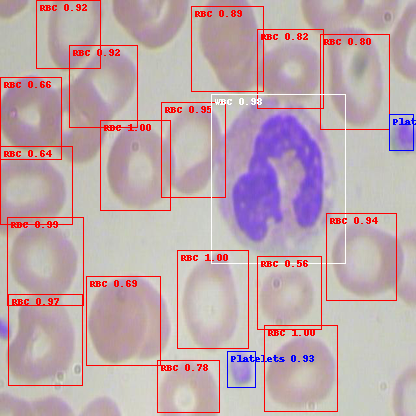
<center>Final result should look something like this</center>

# Imports

Standard imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image
import PIL.ImageDraw
import xml.etree.ElementTree as ET

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

Library versions

In [3]:
print('python:    ', sys.version.split()[0])
print('numpy:     ', np.__version__)
print('pillow:    ', PIL.__version__)
print('tensorflow:', tf.__version__)

python:     3.7.4
numpy:      1.16.5
pillow:     6.2.0
tensorflow: 1.14.0


# Configuration

Download from [github](https://github.com/Shenggan/BCCD_Dataset), git commit `e395c0b9af61a852cdfd04e5081548cb7fa8a063`

In [4]:
dataset_location = '/home/marcin/Datasets/blood-cells/BCCD_Dataset/BCCD'

Anchor boxes from original paper, really should be tuned to this dataset

In [5]:
anchors = ((0.57273, 0.677385),  # anchor 1, width & height, unit: cell_size
           (1.87446, 2.06253),   # anchor 2,
           (3.33843, 5.47434),   # ...
           (7.88282, 3.52778),
           (9.77052, 9.16828))

Define classes

In [6]:
classes = ['WBC', 'RBC', 'Platelets']
colors = [(255,255,255), (255,0,0), (0,0,255)]
class_weights = [1.0, 1.0, 1.0]
lambda_coord = 1.0
lambda_noobj = 1.0
lambda_obj = 5.0
lambda_class = 1.0

# Load Data

Find annotation .xml files

In [7]:
images_location = os.path.join(dataset_location, 'JPEGImages')
annotations_location = os.path.join(dataset_location, 'Annotations')

filename_list_xml = sorted(os.listdir(annotations_location))
display(filename_list_xml[:3])

['BloodImage_00000.xml', 'BloodImage_00001.xml', 'BloodImage_00002.xml']

Helper wrappers

In [8]:
class ImageWrapper:
    def __init__(self, filepath, width, height, depth):
        self.filepath = filepath
        self.width = width
        self.height = height
        self.depth = depth
        self.objects = []
    def __str__(self):
        return f'{self.filepath}\n' \
               f'w:{self.width} h:{self.height} d:{self.depth}'

In [9]:
class BBoxWrapper:
    def __init__(self, classid, score, xmin ,ymin, xmax, ymax):
        self.classid = classid
        self.score = score
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    def __str__(self):
        return f'{self.classid} {self.score} ' \
               f'{self.xmin} {self.ymin} {self.xmax} {self.ymax}'

Read all annotations

In [10]:
image_wrapper_list = []

for filename_xml in filename_list_xml:       # 'BloodImage_00000.xml'
    filepath_xml = os.path.join(             # '/../../BloodImage_00000.xml'
        annotations_location, filename_xml)  
    tree = ET.parse(filepath_xml)            # xml.etree.ElementTree.ElementTree
    
    filename = tree.find('./filename').text  # 'BloodImage_00000'
    w = tree.find('./size/width').text       # '640'
    h = tree.find('./size/height').text      # '480'
    d = tree.find('./size/depth').text       # '3'
    
    filepath_jpg = os.path.join(             # '/../../BloodImage_00000.jpg'
        images_location, filename) #+'.jpg')
    
    assert os.path.isfile(filepath_jpg)
    
    iw = ImageWrapper(filepath=filepath_jpg, width=int(w),
                      height=int(h), depth=int(d))
    
    object_elemnts = tree.findall('./object')  # [xml.etree.ElementTree.ElementTree, ...]
    for obj_el in object_elemnts:
    
        name = obj_el.find('./name').text         # 'RBC'
        xmin = obj_el.find('./bndbox/xmin').text  # '233'
        ymin = obj_el.find('./bndbox/ymin').text  # '368'
        xmax = obj_el.find('./bndbox/xmax').text  # '338'
        ymax = obj_el.find('./bndbox/ymax').text  # '452'
        
        if name in classes:
            classid = classes.index(name)
            bbw = BBoxWrapper(classid=classid, score=1.0,
                              xmin=int(xmin), ymin=int(ymin),
                              xmax=int(xmax), ymax=int(ymax))
        
            iw.objects.append(bbw)
        else:
            raise  # pass
        
    image_wrapper_list.append(iw)

Show example

In [11]:
for img_wrapper in image_wrapper_list:
    print(img_wrapper)
    for bbox_wrapper in img_wrapper.objects:
        print('  ', classes[bbox_wrapper.classid], bbox_wrapper)
    break

/home/marcin/Datasets/blood-cells/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg
w:640 h:480 d:3
   WBC 0 1.0 260 177 491 376
   RBC 1 1.0 78 336 184 435
   RBC 1 1.0 63 237 169 336
   RBC 1 1.0 214 362 320 461
   RBC 1 1.0 414 352 506 445
   RBC 1 1.0 555 356 640 455
   RBC 1 1.0 469 412 567 480
   RBC 1 1.0 1 333 87 437
   RBC 1 1.0 4 406 95 480
   RBC 1 1.0 155 74 247 174
   RBC 1 1.0 11 84 104 162
   RBC 1 1.0 534 39 639 139
   RBC 1 1.0 547 195 640 295
   RBC 1 1.0 388 11 481 111
   RBC 1 1.0 171 175 264 275
   RBC 1 1.0 260 1 374 83
   RBC 1 1.0 229 91 343 174
   RBC 1 1.0 69 144 184 235
   RBC 1 1.0 482 131 594 230
   RBC 1 1.0 368 89 464 176


**Data Loader**

This class does all the heavy lifting of feeding images to training loop

In [12]:
class BloodSequence(tf.keras.utils.Sequence):
    def __init__(self, image_wrapper_list, target_size, number_cells,
                 anchors, class_names, batch_size,
                 preprocess_images_function=None,
                 shuffle=False):
        """Keras dataloader
        
        Params:
            image_wrapper_list: list of ImageWrapper objects
            target_size (int): image size in pixels, e.g. 416
            number_cells (int): how many cells, e.g. 13
            anchors (list): list of anchors in format: [(w1,h1),(w2,h2),...]
            class_names (list): e.g. ['WBC', 'RBC', 'Platelets']
            batch_size (int): mini-batch size
            preprocess_images_function: funct. to normalize input image
            shuffle (bool): shuffle images
        """
        assert isinstance(image_wrapper_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert isinstance(number_cells, int) and number_cells > 0
        assert isinstance(anchors, (tuple, list))
        assert isinstance(anchors[0], (tuple, list)) and len(anchors[0]) == 2  # 2 = w,h
        assert isinstance(class_names, (tuple, list))
        assert isinstance(class_names[0], str)
        assert isinstance(batch_size, int) and batch_size > 0
        assert preprocess_images_function is None or callable(preprocess_images_function)
        assert isinstance(shuffle, bool)
        
        if target_size / number_cells != 32:
            raise ValueError(
                'target_size and number_cells must be such that cell width is 32')
        self.cell_width = 32
        self.cell_height = 32
    
        self.image_wrapper_list = np.array(image_wrapper_list)  # for advanced indexing
        self.target_size = target_size        # int, e.g. 416
        self.number_cells = number_cells      # int, e.g. 13
        self.anchors = anchors                # [[anchor_1_w, anchor_1_h], ...]
        self.class_names = class_names                  # ['RBC', ...]
        self.class_ids = list(range(len(class_names)))  # [0, 1, ...]
        self.batch_size = batch_size
        self.preprocess_images_function = preprocess_images_function
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.ceil(len(self.image_wrapper_list) / self.batch_size))
    
    
    def __getitem__(self, idx):
        """
        Images format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, target_size, target_size, 3)
        Targets format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, nb_cells, nb_cells, nb_anchors, 5 + nb_classes)
         - where last dim is arranged as follows:
             [bbox_center_x, bbox_center_y, bbox_width, bbox_height, confidence, classes]
           + bbox_ params are expressed in cell_width/height as a unit
           + confidence is "objectness" from the paper
           + classes is a one-hot encoded object class
           + e.g. [1.5, 2.5, 2, 3, 1, 0, 0, 1]
                                      ^--^--^-- class
                                   ^----------- object present (if zero ignore other vals)    
                                ^------ bbox is 3x cells wide (32*3=96 pixels)
                             ^----- bbox is 2x cells tall
                          ^---- bbox center is in the 3rd row of cell grid
                    ^--- bbox center is in 2nd column of cell grid
         
         
        Returns:
            (images, targets): two np.ndarray with training mini-batch
        """
        
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_iw = self.image_wrapper_list[batch_i]    # [ImageWrapper, ...]
        
        images_shape = (
            len(batch_iw),      # batch size
            self.target_size,   # width, e.g 416
            self.target_size,   # height, e.g. 416
            3,                  # nb channels, RGB
        )
        
        targets_shape = (
            len(batch_iw),                  # batch size
            self.number_cells,              # nb cells x, 13
            self.number_cells,              # nb cells y, 13
            len(self.anchors),              # nb anchors
            4 + 1 + len(self.class_names))  # x,y,w,h, conf, clases
        
        images_arr = np.zeros(shape=images_shape, dtype=np.uint8)
        targets_arr = np.zeros(shape=targets_shape, dtype=float)
        
        
        for i, img_wrapper in enumerate(batch_iw):

            #
            #   Load Image
            #
            image = PIL.Image.open(img_wrapper.filepath)
            image_w, image_h = image.size
            image_new = image.resize((self.target_size, self.target_size),
                                     resample=PIL.Image.LANCZOS)
            images_arr[i] = np.array(image_new)
            
            #
            #   Load Objects
            #
            for obj_wrapper in img_wrapper.objects:
                
                if obj_wrapper.classid not in self.class_ids:
                    continue
                
                xmin, ymin = obj_wrapper.xmin, obj_wrapper.ymin  # unit: input img pixels
                xmax, ymax = obj_wrapper.xmax, obj_wrapper.ymax
                
                center_x_px = (xmin + xmax) / 2    # bounding box center
                center_y_px = (ymin + ymax) / 2    # unit: input img pixels, [0..image_h]
                size_w_px = (xmax-xmin)            # bounding box width & height
                size_h_px = (ymax-ymin)            # unit: input img pixels, [0..image_h]
                
                center_x_01 = (center_x_px / image_w)  # range: [0..1]
                center_y_01 = (center_y_px / image_h)
                size_w_01 = size_w_px / image_w
                size_h_01 = size_h_px / image_h
                
                center_x_cells = center_x_01 * self.number_cells  # range: [0..nb_cells]
                center_y_cells = center_y_01 * self.number_cells
                size_w_cells = size_w_01 * self.number_cells
                size_h_cells = size_h_01 * self.number_cells
                
                grid_x_loc = int(np.floor(center_x_cells))
                grid_y_loc = int(np.floor(center_y_cells))
                
                # find highest IoU anchor
                best_anchor_loc, best_iou = 0, 0
                for anchor_loc, anchor_wh in enumerate(self.anchors):
                    (anchor_w_cells, anchor_h_cells) = anchor_wh
                    
                    intersect_w = min(size_w_cells, anchor_w_cells)
                    intersect_h = min(size_h_cells, anchor_h_cells)
                    intersect_area = intersect_w * intersect_h
                    union_w = max(size_w_cells, anchor_w_cells)
                    union_h = max(size_h_cells, anchor_h_cells)
                    union_area = union_w * union_h
                    
                    IoU = intersect_area / union_area
                    if IoU > best_iou:
                        best_iou = IoU
                        best_anchor_loc = anchor_loc
                        
                class_idx = obj_wrapper.classid
                target = np.zeros(shape=(4 + 1 + len(self.class_names)), dtype=float)
                target[0] = center_x_cells
                target[1] = center_y_cells
                target[2] = size_w_cells
                target[3] = size_h_cells
                target[4] = 1.0
                target[5 + class_idx] = 1.0
                
                targets_arr[i, grid_y_loc, grid_x_loc, best_anchor_loc] = target
                
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        
        return images_arr, targets_arr
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_wrapper_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

Input normalization function

In [13]:
def preproc_images(images_arr):
    assert isinstance(images_arr, np.ndarray)
    assert images_arr.dtype == np.uint8
    return images_arr / 255

Create temporary generator for quick test

In [14]:
temp_generator = BloodSequence(image_wrapper_list, target_size=416, number_cells=13, 
                        anchors=anchors, class_names=classes, batch_size=16, shuffle=False,
                       preprocess_images_function=preproc_images)

In [15]:
x_batch, y_batch = temp_generator[0]
print('x_batch.shape:', x_batch.shape)
print('x_batch.dtype:', x_batch.dtype)
print('y_batch.shape:', y_batch.shape)
print('y_batch.dtype:', y_batch.dtype)

x_batch.shape: (16, 416, 416, 3)
x_batch.dtype: float64
y_batch.shape: (16, 13, 13, 5, 8)
y_batch.dtype: float64


Function to decode ground-truth labels into bounding boxes

In [16]:
def decode_y_true(image_np, y_true_np):
    """
    Returns:
        [(x1, y1, x2, y2), ...] - where x1, y1, x2, y2 are coordinates of 
                                  top-left and bottom-right corners of bounding box
                                  in pixels in image, this can be passed to PIL.Draw
    """

    assert isinstance(image_np, np.ndarray)
    assert image_np.shape == (416, 416, 3)
    assert isinstance(y_true_np, np.ndarray)
    assert y_true_np.shape == (13, 13, 5, 8)

    img_h, img_w, _ = image_np.shape

    grid_w, grid_h, nb_anchors, _ = y_true_np.shape

    cell_w = img_w / grid_w  # 32
    cell_h = img_h / grid_h  # 32

    boundig_boxes = []


    for gx in range(grid_w):
        for gy in range(grid_h):
            for ai in range(nb_anchors):
                anchor = y_true_np[gx][gy][ai]
                
                classid = np.argmax(anchor[5:])
                
                if anchor.max() != 0:
                    bbox_center_x = cell_w * anchor[0]
                    bbox_center_y = cell_h * anchor[1]
                    bbox_width = cell_w * anchor[2]
                    bbox_height = cell_h * anchor[3]

                    x1 = bbox_center_x-bbox_width/2
                    y1 = bbox_center_y-bbox_height/2
                    x2 = bbox_center_x+bbox_width/2
                    y2 = bbox_center_y+bbox_height/2

                    boundig_boxes.append(BBoxWrapper(classid, 1.0, x1, y1, x2, y2))
                    
    return boundig_boxes

Function to plot bounding boxes onto image

In [17]:
def plot_boxes(image_np, boundig_boxes, classes, colors, width=1):
    image_h, image_w, _ = image_np.shape

    pil_img = PIL.Image.fromarray((image_np*255).astype(np.uint8))
    draw = PIL.ImageDraw.Draw(pil_img)
        
    for box in boundig_boxes:
        xmin, ymin = int(box.xmin), int(box.ymin)
        xmax, ymax = int(box.xmax), int(box.ymax)
        
        draw.rectangle([xmin, ymin, xmax, ymax], outline=colors[box.classid], width=width)
        draw.text([xmin+4,ymin+2],
                  f'{classes[box.classid]} {box.score:.2f}', fill=colors[box.classid])
    
    del draw
    return pil_img

Show example

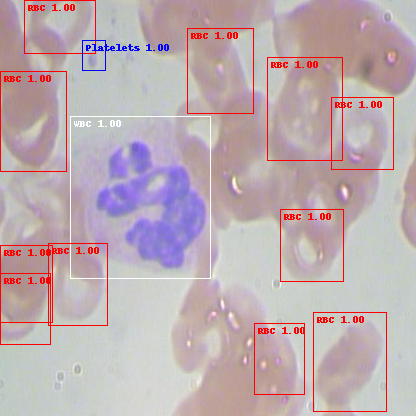

In [18]:
idx = 4
boundig_boxes = decode_y_true(x_batch[idx], y_batch[idx])
pil_img = plot_boxes(x_batch[idx], boundig_boxes, classes, colors)
display(pil_img)

Split train/valid dataset

In [19]:
split = int(0.8*len(image_wrapper_list))
print('Train/Valid split:', split, '/', len(image_wrapper_list)-split)

Train/Valid split: 291 / 73


Create proper generators

In [20]:
train_generator = BloodSequence(image_wrapper_list[:split],
                                target_size=416, number_cells=13, 
                                anchors=anchors, class_names=classes,
                                batch_size=16, shuffle=False,
                                preprocess_images_function=preproc_images)
valid_generator = BloodSequence(image_wrapper_list[split:],
                                target_size=416, number_cells=13, 
                                anchors=anchors, class_names=classes,
                                batch_size=16, shuffle=False,
                                preprocess_images_function=preproc_images)

# Keras Model

In [21]:
from tensorflow.keras.layers import Input, Lambda, Reshape, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model

Helper so we can use `tf.space_to_depth` as a keras layer

In [22]:
class SpaceToDepth(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(SpaceToDepth, self).__init__(**kwargs)
        self.block_size = block_size
    
    def call(self, x):
        return tf.space_to_depth(x, self.block_size)

In [23]:
def conv_block(X, filters, kernel_size, suffix, max_pool=False):
    X = Conv2D(filters, kernel_size, strides=(1,1), padding='same',
               use_bias=False, name='conv'+suffix)(X)
    X = BatchNormalization(name='norm'+suffix)(X)
    X = LeakyReLU(alpha=0.1)(X)
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 2))(X)
    return X

Create YOLOv2 model

In [24]:
def create_yolov2(input_size, grid_size, number_anchors, number_classes):

    assert isinstance(input_size, (tuple, list)) and len(input_size) == 2
    assert isinstance(input_size[0], int) and input_size[0] > 0
    assert isinstance(input_size[1], int) and input_size[1] > 0
    assert isinstance(grid_size, (tuple, list)) and len(grid_size) == 2
    assert isinstance(grid_size[0], int) and grid_size[0] > 0
    assert isinstance(grid_size[1], int) and grid_size[1] > 0

    input_height, input_width = input_size
    grid_height, grid_width = grid_size

    IN = Input(shape=(input_height, input_width, 3))

    X = conv_block(IN, filters=32, kernel_size=(3,3), suffix='_1', max_pool=True)
    X = conv_block(X, filters=64, kernel_size=(3,3), suffix='_2', max_pool=True)
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_3')
    X = conv_block(X, filters=64, kernel_size=(1,1), suffix='_4')
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_5', max_pool=True)
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_6')
    X = conv_block(X, filters=128, kernel_size=(1,1), suffix='_7')
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_8', max_pool=True)
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_9')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_10')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_11')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_12')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_13')

    SK = X  # skip connection

    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_14')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_15')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_16')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_17')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_18')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_19')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_20')

    SK = conv_block(SK, filters=64, kernel_size=(1,1), suffix='_21')
    SK = SpaceToDepth(block_size=2)(SK)
    X = concatenate([SK, X])

    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_22')

    X = Conv2D(filters=number_anchors * (4+1+number_classes),
               kernel_size=(1,1), strides=(1,1), padding='same', name='conv_23')(X)
    
    OUT = Reshape((grid_height, grid_width, number_anchors, 4+1+number_classes))(X)

    model = Model(IN, OUT)
    return model

In [25]:
model = create_yolov2(input_size = (416, 416),  # (height, width)
                      grid_size = (13, 13),     # (height, width)
                      number_anchors = len(anchors),
                      number_classes = len(classes))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [26]:
# model.summary()

# Load YOLOv2 Weights

Function to load pre-trained weights

In [27]:
def load_yolov2_weights(model, filepath, last_layer='leave'):
    pointer = 4
    weights = np.fromfile(filepath, dtype='float32')

    for i in range(1, 23):

        #
        #   Norm layers 1..22
        #
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta = weights[pointer:pointer+size]; pointer += size;
        gamma = weights[pointer:pointer+size]; pointer += size;
        mean = weights[pointer:pointer+size]; pointer += size;
        var = weights[pointer:pointer+size]; pointer += size;

        norm_layer.set_weights([gamma, beta, mean, var])

        #
        #   Conv layers 1..22
        #
        conv_layer = model.get_layer('conv_' + str(i))

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

    #
    #   Conv layer 23
    #
    if last_layer == 'leave':
        pass
    
    elif last_layer == 'load':
        conv_layer = model.get_layer('conv_23')

        size = np.prod(conv_layer.get_weights()[1].shape)
        bias   = weights[pointer:pointer+size]; pointer += size;

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])

        conv_layer.set_weights([kernel, bias])
        
    elif last_layer == 'rand':
        conv_layer = model.get_layer('conv_23') # the last convolutional layer
        weights = conv_layer.get_weights()
        
        output_shape = model.layers[-1].output_shape
        _, grid_w, grid_h, _, _ = output_shape
        
        new_kernel = np.random.normal(size=weights[0].shape) / (grid_w*grid_h)
        new_bias   = np.random.normal(size=weights[1].shape) / (grid_w*grid_h)

        conv_layer.set_weights([new_kernel, new_bias])
    
    else:
        raise ValueError("Parameter last_layer must be 'leave', 'load' or 'rand'.")

Download `yolov2.weights` from [https://pjreddie.com/darknet/yolov2/](https://pjreddie.com/darknet/yolov2/)

In [28]:
np.random.seed(0)  # makes last layer deterministic for testing
load_yolov2_weights(model, 'yolov2.weights', last_layer='rand')

Make sure it works

In [29]:
logits = model.predict(x_batch)

Example

In [30]:
batch_idx = 0
cell_row = 1
cell_col = 8
print('rows are anochor boxes 0..4')
print('   -----------------   logits   -----------------')
print('    x     y     w     h    conf  cls0  cls1  cls2')
print(np.round(logits[batch_idx][cell_row][cell_col], 2))

rows are anochor boxes 0..4
   -----------------   logits   -----------------
    x     y     w     h    conf  cls0  cls1  cls2
[[ 0.12 -0.15 -0.    0.06 -0.01 -0.1   0.22 -0.01]
 [ 0.1   0.12 -0.08  0.06 -0.08 -0.09 -0.03 -0.1 ]
 [ 0.08  0.02  0.06  0.08  0.09  0.01 -0.07 -0.05]
 [-0.02 -0.09 -0.1   0.13  0.09  0.07  0.14  0.1 ]
 [ 0.15 -0.16 -0.15 -0.02 -0.07  0.01  0.1   0.12]]


# Loss Function

This function was mostly copied form [keras-yolo2](https://github.com/experiencor/keras-yolo2). All credit goes to original authors.

I have made **two modifications** to original YOLOv2 loss.

1. I removed one term from the loss function, which was responsible for penalising low IoU false positives. I found that it made almost no difference on model performance (at least at this dataset), while being unreasonably complex to compute. The full version of YOLOv2 the loss function is available at the end of this notebook.
2. I removed the warm-up section. Again, I found it was introducing complexity, while actually making results worse.

The **full YOLOv2** loss function is available in the appending at the bottom of this notebook.

My changes:
* simplify by removing low IoU penalty
* simplify by removing warmup code
* remove statistics (recall) and debug prints
* rewrite and extend comments
* explicitly declare global variables

In [31]:
def yolov2_loss_full(y_true, y_pred):
    """YOLOv2 loss. Note y_true, y_pred are tensors!"""
    global anchors, lambda_coord, lambda_noobj, lambda_obj, lambda_class, class_weights
    
    #
    #   Prepare empty masks
    #
    nb_batch = tf.shape(y_true)[0]
    nb_grid_w = tf.shape(y_true)[1]
    nb_grid_h = tf.shape(y_true)[2]
    nb_anchor = tf.shape(y_true)[3]
    nb_class = tf.shape(y_true)[4] - 5    # substract x,y,w,h,conf fields
    
    coord_mask = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    conf_mask  = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    class_mask = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    
    #
    #   Decode Predictions
    #
    
    # create grid_coord so we can offset predictions by grid cell index
    grid_tiles = tf.tile(tf.range(nb_grid_w), [nb_grid_h])
    grid_resh = tf.reshape(grid_tiles, (1, nb_grid_h, nb_grid_w, 1, 1))
    grid_x = tf.to_float(grid_resh)
    grid_y = tf.transpose(grid_x, (0,2,1,3,4))
    grid_concat = tf.concat([grid_x,grid_y], -1)
    grid_coord = tf.tile(grid_concat, [nb_batch, 1, 1, nb_anchor, 1])
    
    # transform logits to 0..1, then add cell offsets
    # shape [b, gw, gh, a, 2], range [0..gx, 0..gy], dtype float
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + grid_coord
       
    # transform logits to bounding box width and height
    # shape [b, gw, gh, a, 2], range [0..], dtype float
    # value of [1, 1] means bbox is same as anchor, [.5,.5] means half anchor
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchors, [1,1,1,len(anchors),2])
    
    # logits to confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    # for class probabilites keep logits as (passed to cross-entropy later)
    pred_box_class = y_pred[..., 5:]
    
    #
    #   Decode targets
    #
    
    # target xywh are alredy correctly formatted
    # shape [b, gw, gh, a, 2], range [0..gx, 0..gy], dtype float
    # value [1.5, 2.5] means bbox center is aligned with center of cell [1, 2]
    true_box_xy = y_true[..., 0:2]
    true_box_wh = y_true[..., 2:4]
    
    # this whole section basically computes IoU(true_bbox, pred_bbox)
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    # target confidence is defined as: class_prob * IoU(true_bbox, pred_bbox)
    # note that in this dataset class_prob is always 0 or 1
    true_box_conf = iou_scores * y_true[..., 4]
    
    # convert class vector from one-hot to integer [0..]
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    #
    #   Compute 0/1 masks
    #
    
    # coordinate mask: the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * lambda_coord
    
    # confidence mask: the confidence of the ground truth boxes
    conf_mask = conf_mask + (1 - y_true[..., 4]) * lambda_noobj  # <- simplification #1
    conf_mask = conf_mask + y_true[..., 4] * lambda_obj
    
    # class mask: the class of the ground truth boxes
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * lambda_class       
    
    #
    #   Combine the loss
    #
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    return loss

**Test loss function**

Create temporary dataloader

In [32]:
temp_dataloader = BloodSequence(image_wrapper_list, target_size=416, number_cells=13, 
                        anchors=anchors, class_names=classes, batch_size=16, shuffle=False,
                        preprocess_images_function=preproc_images)

Extract one mini batch

In [33]:
x_batch, y_batch = temp_dataloader[0]

Run through the model

In [34]:
y_hat = model.predict(x_batch)

Create loss function graph for testing

In [35]:
y_true_ph = tf.placeholder(tf.float32, shape=(None, 13, 13, 5, 8))
y_pred_ph = tf.placeholder(tf.float32, shape=(None, 13, 13, 5, 8))
loss = yolov2_loss_full(y_true_ph, y_pred_ph)

Instructions for updating:
Use `tf.cast` instead.


Pass through loss function

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res = sess.run(loss, {y_true_ph: y_batch, y_pred_ph: y_hat})

In [37]:
print('result:', res)

result: 1.799284


Result should be as follows:
```
Simple (BCCD dataset):    1.799284
Full   (BCCD dataset):    1.7992942
Simple (kaggle dataset):  0.6796268
Full   (kaggle dataset):  0.6796271

```

**Compile model**

In [38]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=yolov2_loss_full, optimizer=optimizer)

Create optional callbacks

In [39]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

Train the model

In [40]:
hist = model.fit_generator(generator=train_generator, 
                           steps_per_epoch=len(train_generator), 
                           epochs=100, 
                           validation_data=valid_generator,
                           validation_steps=len(valid_generator),
                           callbacks=[checkpoint_cb],  # [earlystop_cb, checkpoint_cb]
                           max_queue_size=3)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
18/19 [===========================>..] - ETA: 0s - loss: 1.0488
Epoch 00001: val_loss improved from inf to 0.64269, saving model to model.h5
19/19 [==============================] - 18s 947ms/step - loss: 1.0237 - val_loss: 0.6427
Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.3789
Epoch 00002: val_loss improved from 0.64269 to 0.38036, saving model to model.h5
19/19 [==============================] - 7s 384ms/step - loss: 0.3772 - val_loss: 0.3804
Epoch 3/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2233
Epoch 00003: val_loss did not improve from 0.38036
19/19 [==============================] - 5s 267ms/step - loss: 0.2201 - val_loss: 0.3825
Epoch 4/100
18/19 [===========================>..] - ETA: 0s - loss: 0.1345
Epoch 00004: val_loss improved from 0.38036 to 0.25244, saving model to model.h5
19/19 [==============================] - 7s 

18/19 [===========================>..] - ETA: 0s - loss: 0.0143
Epoch 00035: val_loss did not improve from 0.11086
19/19 [==============================] - 5s 279ms/step - loss: 0.0141 - val_loss: 0.1184
Epoch 36/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0141
Epoch 00036: val_loss did not improve from 0.11086
19/19 [==============================] - 5s 276ms/step - loss: 0.0141 - val_loss: 0.1145
Epoch 37/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0128
Epoch 00037: val_loss did not improve from 0.11086
19/19 [==============================] - 5s 276ms/step - loss: 0.0126 - val_loss: 0.1155
Epoch 38/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0127
Epoch 00038: val_loss did not improve from 0.11086
19/19 [==============================] - 5s 282ms/step - loss: 0.0130 - val_loss: 0.1115
Epoch 39/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0120
Epoch 00039: val_loss did not improve from 0.11086
19/19 [==========

Epoch 73/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0082
Epoch 00073: val_loss did not improve from 0.10842
19/19 [==============================] - 5s 276ms/step - loss: 0.0080 - val_loss: 0.1180
Epoch 74/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0085
Epoch 00074: val_loss did not improve from 0.10842
19/19 [==============================] - 5s 275ms/step - loss: 0.0083 - val_loss: 0.1098
Epoch 75/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0068
Epoch 00075: val_loss did not improve from 0.10842
19/19 [==============================] - 5s 279ms/step - loss: 0.0070 - val_loss: 0.1119
Epoch 76/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0066
Epoch 00076: val_loss did not improve from 0.10842
19/19 [==============================] - 5s 280ms/step - loss: 0.0065 - val_loss: 0.1117
Epoch 77/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0052
Epoch 00077: val_loss did not improve from 0.10842
19/1

Optionally save results for later

In [41]:
# with open('trace_full.pkl', 'wb') as f:
#     pickle.dump(hist.history, f)

Optionally load past results

In [42]:
# with open('trace_full.pkl', 'rb') as f:
#     hist_trace_full = pickle.load(f)

(0, 0.2)

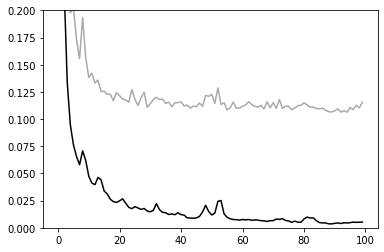

In [43]:
# plt.plot(hist_trace_full['loss'], c='green')
# plt.plot(hist_trace_full['val_loss'], c='lightgreen')
plt.plot(hist.history['loss'], c='black')
plt.plot(hist.history['val_loss'], c='darkgray')
plt.ylim((0, .2))

# Decode Outputs

Load best weights from training

In [44]:
model.load_weights('model.h5')

Few helpers to decode logits

In [45]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [46]:
def softmax(x):
    max_ = np.max(x, axis=-1, keepdims=True)
    ex = np.exp(x - max_)
    ex_sum = np.sum(ex, axis=-1, keepdims=True)
    return ex / ex_sum

In [47]:
def iou(bboxA, bboxB):
    # intersect rectangle
    xmin = max(bboxA.xmin, bboxB.xmin)
    ymin = max(bboxA.ymin, bboxB.ymin)
    xmax = min(bboxA.xmax, bboxB.xmax)
    ymax = min(bboxA.ymax, bboxB.ymax)
    
    areaI = max(0, xmax-xmin) * max(0, ymax-ymin)
    areaA = (bboxA.xmax-bboxA.xmin) * (bboxA.ymax-bboxA.ymin)
    areaB = (bboxB.xmax-bboxB.xmin) * (bboxB.ymax-bboxB.ymin)
    
    IoU = areaI / (areaA + areaB - areaI)
    return IoU

Decode neural network predictions (slightly different to ground truth)

In [48]:
def decode_y_pred(logits, img_shape, classes, anchors, obj_threshold=0.3):
    nb_grid_h, nb_grid_w, nb_anchor, _ = logits.shape
    nb_class = logits.shape[3] - 5  # remove x,y,w,h,conf.
    assert nb_class == len(classes)
    
    proc_logits = lambda xywh: (sigmoid(xywh[0]), sigmoid(xywh[1]),
                                np.exp(xywh[2]), np.exp(xywh[3]))
    
    logits_xywh = logits[...,:4]                        # shape (13, 13, 5, 4)
    bbox_xywh = np.apply_along_axis(                    # shape (13, 13, 5, 4)
        func1d=proc_logits, axis=-1, arr=logits_xywh)
    
    # all have shape: [grid_h, grid_w, nb_anchor, nb_class]
    confidences = np.expand_dims(sigmoid(logits[..., 4]),-1)
    probabilities = softmax(logits[..., 5:])
    scores = confidences * probabilities
    
    boxes = []
    for ri in range(nb_grid_h):
        for ci in range(nb_grid_w):
            for ai in range(nb_anchor):
                best_class_score = scores[ri, ci, ai].max()
                if best_class_score > obj_threshold:
                    
                    classid = np.argmax(scores[ri, ci, ai])     # int
                    img_h, img_w, _ = img_shape
                    
                    x, y, w, h = bbox_xywh[ri, ci, ai]
                    x = (ci + x) / nb_grid_w * img_w            # unit image [0..1]
                    y = (ri + y) / nb_grid_h * img_h            # unit image [0..1]
                    w = anchors[ai][0] * w / nb_grid_w * img_w  # unit image [0..1]
                    h = anchors[ai][1] * h / nb_grid_h * img_h  # unit image [0..1]
                    
                    box = BBoxWrapper(classid, best_class_score,
                                      xmin=x-w/2, ymin=y-h/2,
                                      xmax=x+w/2, ymax=y+h/2)
                    boxes.append(box)
    return boxes

Non-max suppression

In [49]:
def suppress(boxes, classes, nms_threshold):
    
    suppressed = []

    for classid in range(len(classes)):
        
        indices = np.argsort([box.score for box in boxes
                             if box.classid == classid])
        indices = indices[::-1]  # reverse
                
        for i in range(len(indices)):
            index_i = indices[i]
            
            if boxes[index_i] in suppressed: 
                continue
            
            for j in range(i+1, len(indices)):
                index_j = indices[j]


                iou2 = iou(boxes[index_i], boxes[index_j])
                if iou2 >= nms_threshold:
                    #boxes[index_j].classes[c] = 0
                    suppressed.append(boxes[index_j])

    boxes = [box for box in boxes if box not in suppressed]
    
    return boxes   

Pick image from validation set

In [57]:
x_batch, y_batch = valid_generator[2]
image_np = x_batch[5]

Pass through neural network

In [58]:
y_hat = model.predict(np.expand_dims(image_np, 0))[0]

Get bounding boxes

In [59]:
boxes = decode_y_pred(y_hat, image_np.shape, classes=classes,
                obj_threshold=0.5, anchors=anchors)
boxes = suppress(boxes, classes=classes, nms_threshold=0.3)

Plot result

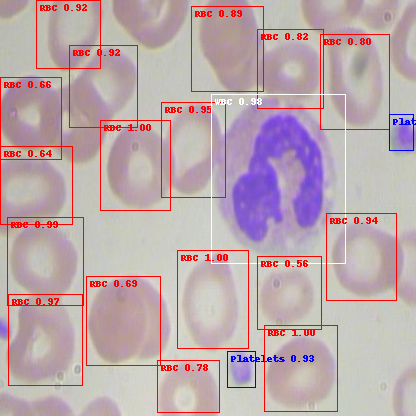

In [60]:
image = plot_boxes(image_np, boxes, classes, colors, width=1)
display(image)

# Appendix

Full YOLOv2 loss function

In [61]:
def yolov2_loss_full(y_true, y_pred):
    global anchors, lambda_coord, lambda_noobj, lambda_obj, lambda_class, class_weights
    
    #
    #   Prepare empty masks
    #
    nb_batch = tf.shape(y_true)[0]
    nb_grid_w = tf.shape(y_true)[1]
    nb_grid_h = tf.shape(y_true)[2]
    nb_anchor = tf.shape(y_true)[3]
    nb_class = tf.shape(y_true)[4] - 5    # substract x,y,w,h,conf fields
    
    coord_mask = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    conf_mask  = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    class_mask = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    
    #
    #   Decode Predictions
    #
    
    # create grid_coord so we can offset predictions by grid cell index
    grid_tiles = tf.tile(tf.range(nb_grid_w), [nb_grid_h])
    grid_resh = tf.reshape(grid_tiles, (1, nb_grid_h, nb_grid_w, 1, 1))
    grid_x = tf.to_float(grid_resh)
    grid_y = tf.transpose(grid_x, (0,2,1,3,4))
    grid_concat = tf.concat([grid_x,grid_y], -1)
    grid_coord = tf.tile(grid_concat, [nb_batch, 1, 1, nb_anchor, 1])
    
    # transform logits to 0..1, then add cell offsets
    # shape [b, gw, gh, a, 2], range [0..gx, 0..gy], dtype float
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + grid_coord
       
    # transform logits to bounding box width and height
    # shape [b, gw, gh, a, 2], range [0..], dtype float
    # value of [1, 1] means bbox is same as anchor, [.5,.5] means half anchor
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchors, [1,1,1,len(anchors),2])
    
    # logits to confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    # for class probabilites keep logits as (passed to cross-entropy later)
    pred_box_class = y_pred[..., 5:]
    
    #
    #   Decode targets
    #
    
    # target xywh are alredy correctly formatted
    # shape [b, gw, gh, a, 2], range [0..gx, 0..gy], dtype float
    # value [1.5, 2.5] means bbox center is aligned with center of cell [1, 2]
    true_box_xy = y_true[..., 0:2]
    true_box_wh = y_true[..., 2:4]
    
    # this whole section basically computes IoU(true_bbox, pred_bbox)
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    # target confidence is defined as: class_prob * IoU(true_bbox, pred_bbox)
    # note that in this dataset class_prob is always 0 or 1
    true_box_conf = iou_scores * y_true[..., 4]
    
    # convert class vector from one-hot to integer [0..]
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    #
    #   Penalty for low IoU predictions (optionsl)
    #
    
    # confidence mask: penelize predictors + penalize boxes with low IOU
    shape = tf.shape(y_true)
    y_true_reduce = y_true[...,0:4]
    y_true_reshape = tf.reshape(y_true_reduce, shape=(shape[0], -1, 4))
    y_true_max = tf.reduce_max(y_true_reshape, axis=-1)
    y_true_argsorg = tf.argsort(y_true_max, axis=-1)
    y_true_range = tf.tile(tf.expand_dims(tf.range(shape[0]), 1), [1, 845])
    y_true_stack = tf.stack([y_true_range, y_true_argsorg], axis=-1)
    y_true_2 = tf.gather_nd(y_true_reshape, y_true_stack)
    y_true_3 = y_true_2[:,-50:,:]  # 50 is box buffer size
    y_true_3d = tf.expand_dims(y_true_3, axis=1)
    y_true_3dd = tf.expand_dims(y_true_3d, axis=1)
    y_true_3ddd = tf.expand_dims(y_true_3dd, axis=1)
    true_xy = y_true_3ddd[..., 0:2]
    true_wh = y_true_3ddd[..., 2:4]
    
    # this whole section basically computes IoU(true_bbox, pred_bbox)
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    best_ious = tf.reduce_max(iou_scores, axis=4)
    
    #
    #   Compute 0/1 masks
    #
    
    # coordinate mask: the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * lambda_coord
    
    # confidence mask: the confidence of the ground truth boxes
    # conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * lambda_noobj
    conf_mask = conf_mask +                                (1 - y_true[..., 4]) * lambda_noobj
    conf_mask = conf_mask + y_true[..., 4] * lambda_obj
    
    # class mask: the class of the ground truth boxes
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * lambda_class       
    

    #
    #   Warmup (optional)
    #
#     no_boxes_mask = tf.to_float(coord_mask < lambda_coord/2.)
#     seen = tf.assign_add(seen, 1.)
#     num_warmup = 100
#     true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, num_warmup),
#         lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
#                  true_box_wh + tf.ones_like(true_box_wh)*np.reshape(anchors,[1,1,1,len(anchors),2])*no_boxes_mask, 
#                  tf.ones_like(coord_mask)],
#         lambda: [true_box_xy, 
#                  true_box_wh,
#                  coord_mask])
    
    #
    #   Combine the loss
    #
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    
    #
    #   Recall and debug (optional)
    #  
#     nb_true_box = tf.reduce_sum(y_true[..., 4])
#     nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
#     batch_recall = nb_pred_box/(nb_true_box + 1e-6)  # mini-batch recall

#     loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
#     loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
#     loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
#     loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
#     loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
#     loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
#     loss = tf.Print(loss, [batch_recall], message='Current Recall \t', summarize=1000)
    
    return loss